In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import tensorflow as tf
from copy import deepcopy
from tqdm import tqdm

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tensorflow.python.ops import gen_audio_ops as audio_ops
#from tensorflow.op.audio import Mfcc
from tensorflow.python.util import compat

from keras import backend as K
import datetime
import time
import pandas as pd
import io
#tf.compat.v1.disable_eager_execution()

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [54]:
class config:
  DIRECTORY_PATH = "./KeyWord Spotting"
  DATADIR_PATH = DIRECTORY_PATH + "/data"
  model_name = "tiny"
  BASELINE_CHECKPOINT_PATH = DIRECTORY_PATH + "/" + model_name + "/"
  POST_TRAINING_QUANTIZATION_PATH = DIRECTORY_PATH + "/models/post_training_quantization"
  TFLITE_MODEL_NAME = "float_" + model_name + "_model.tflite"
  FLOAT_MODEL_TFLITE = os.path.join(POST_TRAINING_QUANTIZATION_PATH, TFLITE_MODEL_NAME)
  QUANT_MODEL_NAME = "quant_" + model_name + "_model.tflite"
  QUANT_MODEL_TFLITE = os.path.join(POST_TRAINING_QUANTIZATION_PATH, QUANT_MODEL_NAME)
  TRAINING_DATA_SIZE = 0.8
  VALIDATION_DATA_SIZE = 0.2
  TEST_DATA_SIZE = 0.2
  BATCH_SIZE = 64
  NUM_EPOCHS = 150
  LEARNING_RATE = 0.001
  commands = ['yes', 'up', 'right', 'stop', 'down', 'go', 'left', 'no']
  AUTOTUNE = tf.data.AUTOTUNE
  log_dir = DIRECTORY_PATH+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  file_writer = tf.summary.create_file_writer(log_dir + '/metrics')
  file_writer_image = tf.summary.create_file_writer(log_dir + "/images")
  file_writer.set_as_default()

class Params:
  sample_rate: float
  stft_window_useconds : float
  stft_hop_useconds: float
  mel_bands : int
  mel_min_hz : float
  mel_max_hz : float
  log_offset : float = 0.001
  patch_window_seconds : float = 0.96
  path_hop_seconds : float = 0.48

  def __init__(self, sample_rate,stft_window,stft_hop,mel_bins,min_hz,max_hz):
     self.sample_rate = sample_rate
     self.stft_window_useconds = stft_window
     self.stft_hop_useconds = stft_hop
     self.mel_bands = mel_bins
     self.mel_min_hz = min_hz
     self.mel_max_hz = max_hz

  @property
  def patch_frames(self):
    return (int(round(self.patch_window_seconds / self.stft_hop_seconds)))

mel_bins =40
max_hz = 8000
min_hz = 0
stft_window =30
stft_hop = 10
sample_rate = 16000

_params = Params(sample_rate,stft_window,stft_hop,mel_bins,min_hz,max_hz)
kws_config = config


In [3]:
def download_data(data_dir):
  """
  Function to load the train and test dataset
  """
  if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir=data_dir)

def get_commands(data_dir):
  """
  Function to load labels
  """
  if pathlib.Path(data_dir).exists():
     commands = np.array(tf.io.gfile.listdir(str(data_dir)))
     commands = commands[commands != 'README.md']
     print('Commands:', commands)
     return commands

In [4]:
def get_audio(data_dir):
  """
   function to extract the audio files and into a list
  """
  files = []
  #for i in commands:
  #  filenames += tf.io.gfile.glob(str(data_dir) + '/' + i + '/*')
  files = tf.io.gfile.glob(str(data_dir) + '/*/*')
  files = tf.random.shuffle(files)
  num_samples = len(files)
  print('Number of total examples:', num_samples)
  commands = get_commands(data_dir)
  print('Number of examples per label:',
          len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
  return files

#go_filenames = tf.io.gfile.glob(str(data_dir) + '/go/*')
#no_filenames = tf.io.gfile.glob(str(data_dir) + '/no/*')
#print('Example file tensor:', filenames[0])

# Obtain Training and Validation Data Splits
def get_data_split(data_dir):
  """
   Obtain Training and Validation Data Splits
  """
  download_data(pathlib.Path(data_dir))
  data_dir = data_dir + '/mini_speech_commands'
  audio_files = get_audio(pathlib.Path(data_dir))
  total_data = len(audio_files)
  train_size = int(kws_config.TRAINING_DATA_SIZE*total_data)
  val_size = int(kws_config.VALIDATION_DATA_SIZE*total_data)
  test_size = int(kws_config.TEST_DATA_SIZE*total_data)
  train_files = audio_files[:train_size]
  val_files = audio_files[train_size:train_size+val_size]
  test_files = audio_files[-test_size:]
  print('Training set size', len(train_files))
  print('Validation set size', len(val_files))
  print('Test set size', len(test_files))
  return train_files,val_files,test_files

def get_test_data(data_dir):
  data_dir = data_dir + '/mini_speech_commands'
  audio_files = get_audio(pathlib.Path(data_dir))
  total_data = len(audio_files)
  test_size = int(kws_config.TEST_DATA_SIZE*total_data)
  test_files = audio_files[-test_size:]
  print('Test set size', len(test_files))
  return test_files

In [5]:
#reading audio files
# tf.audio.decode_wav convert wav file to numberical tensor

# sample rate of the wave is 16khz values representing (amplitude) -32768, 32767
#tf.audio.decode_wav normalize the values to the range [-1,1]

def decode_audio(audio_wave):
  audio_wav, _ = tf.audio.decode_wav(audio_wave,desired_channels=1,desired_samples=16000)
  return tf.squeeze(audio_wav, axis=-1)
  #foreground_volume_placeholder_ = tf.compat.v1.placeholder(
  #        tf.float32, [], name='foreground_volume')
  #scaled_foreground = tf.multiply(audio_wave,
  #                                    foreground_volume_placeholder_)
      # Shift the sample's start position, and pad any gaps with zeros.
  #time_shift_padding_placeholder_ = tf.compat.v1.placeholder(
  #        tf.int32, [2, 2], name='time_shift_padding')
  #time_shift_offset_placeholder_ = tf.compat.v1.placeholder(
  #        tf.int32, [2], name='time_shift_offset')
  #padded_foreground = tf.pad(
  #        tensor=scaled_foreground,
  #        paddings=time_shift_padding_placeholder_,
  #        mode='CONSTANT')
  #sliced_foreground = tf.slice(padded_foreground,
  #                                 time_shift_offset_placeholder_,
  #                                 [desired_samples, -1])

#get label for wave
def get_label(file_path):
   parts = tf.strings.split(file_path,os.path.sep)

#you will use indexing here instead of tuple unpacking to enable this to in
#work in a tensorflow graph
   return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_bin = tf.io.read_file(file_path)
  waveform= decode_audio(audio_bin)
  return waveform,label

In [7]:
#normailize inputs
def normalize_waveforms(x):
    """ notmalize each waveform of a set

    parameters:
    x: the dataset to normalize

    returns:

    the same set with each waveform normalized
    """

    max_nums = np.max(np.absolute(x),axis=1)
    zeros = np.where(max_nums==0)
    max_nums[zeros] = 1
    return x/max_nums[:,None]

def normalize_spectrograms(x):
    """Normalize each spectrogram of a set
    Parameters:
    x: the dataset to normalize
    Returns:
    The same set with each spectrogram normalized.
    """
    x_2 = np.zeros_like(x)
    for i, example in enumerate(x):
        x_2[i] = example/np.max(np.abs(example))

    return x_2


def normalize_2D(x):
    """Normalize a 2D image
    """

    x_2 = deepcopy(x)
    eps = 1e-10

    means = np.mean(x_2, axis = (1,2))
    std = np.std(x_2,axis = (1,2))

    return (x_2-means[:,None,None])/(std[:,None,None]+eps)

def make_oh(y):
    N = len(y)
    n_classes = len(np.unique(y))

    y_oh = np.zeros((N,n_classes))

    for i in range(N):
        col = int(y[i])
        y_oh[i,col] = 1

    return y_oh

In [8]:
#spectrgram conversio
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([_params.sample_rate] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  window_size_samples = int(16000*_params.stft_window_useconds/1000)
  window_size_stride =  int(16000*_params.stft_hop_useconds/1000)
  fft_length = 2 ** int(np.ceil(np.log(window_size_samples)/ np.log(2.0)))
  spectrogram = tf.signal.stft(
     equal_length, frame_length=window_size_samples, frame_step=window_size_stride,fft_length=fft_length)
  print('Spectrogram shape:', spectrogram.shape)
  #spectrogram = audio_ops.audio_spectrogram(equal_length,window_size_samples,window_size_stride,magnitude_squared=True)
  spectrogram = tf.abs(spectrogram)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = fft_length // 2 + 1
  print("number of mel_bands", num_spectrogram_bins)
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 40
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      _params.mel_bands, num_spectrogram_bins, _params.sample_rate, _params.mel_min_hz,_params.mel_max_hz)

  #mel_spectrograms = tf.tensordot(
  #          spectrogram, linear_to_mel_weight_matrix, 1)

  mel_spectrograms = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
  mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
                linear_to_mel_weight_matrix.shape[-1:]))


  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  print("mel_spectrogram_shape", log_mel_spectrograms.shape)

  # Compute MFCCs from log_mel_spectrograms and take the first 40.
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrograms)[..., :64]

  spectrogram = tf.abs(spectrogram)
  print('mfcc shape:', mfccs.shape)
  return spectrogram,mfccs


In [9]:
#mel spectrgram conversion
def get_melspectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([_params.sample_rate] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  window_size_samples = int(16000*_params.stft_window_useconds/1000)
  window_size_stride =  int(16000*_params.stft_hop_useconds/1000)
  fft_length = 2 ** int(np.ceil(np.log(window_size_samples)/ np.log(2.0)))
  spectrogram = tf.signal.stft(
     equal_length, frame_length=window_size_samples, frame_step=window_size_stride,fft_length=fft_length)
  print('Spectrogram shape:', spectrogram.shape)
  #spectrogram = audio_ops.audio_spectrogram(equal_length,window_size_samples,window_size_stride,magnitude_squared=True)
  spectrogram = tf.abs(spectrogram)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = fft_length // 2 + 1
  print("number of mel_bands", num_spectrogram_bins)
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 40
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      _params.mel_bands, num_spectrogram_bins, _params.sample_rate, _params.mel_min_hz,_params.mel_max_hz)

  #mel_spectrograms = tf.tensordot(
  #          spectrogram, linear_to_mel_weight_matrix, 1)

  mel_spectrograms = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
  mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
                linear_to_mel_weight_matrix.shape[-1:]))


  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  print("mel_spectrogram_shape", log_mel_spectrograms.shape)

  spectrogram = tf.abs(spectrogram)
  return spectrogram,log_mel_spectrograms

In [10]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram,mfccs= get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  #mfccs = tf.expand_dims(mfccs,1)
  label_id = tf.argmax(label == kws_config.commands)
  return spectrogram,label_id

def get_melspectrogram_and_label_id(audio, label):
  _,mel_spectrogram= get_melspectrogram(audio)
  mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)
  label_id = tf.argmax(label == kws_config.commands)
  return mel_spectrogram,label_id

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=kws_config.AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=kws_config.AUTOTUNE)
  return output_ds

def get_mfcc_and_label_id(audio, label):
  spectrogram,mfccs = get_spectrogram(audio)
  #spectrogram = tf.expand_dims(spectrogram, -1)
  mfccs = tf.expand_dims(mfccs,-1)
  label_id = tf.argmax(label == kws_config.commands)
  return  mfccs, label_id

def preprocess_mfccdataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=kws_config.AUTOTUNE)
  output_ds = output_ds.map(
      get_mfcc_and_label_id,  num_parallel_calls=kws_config.AUTOTUNE)
  return output_ds

def preprocess_meldataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=kws_config.AUTOTUNE)
  output_ds = output_ds.map(
      get_melspectrogram_and_label_id,  num_parallel_calls=kws_config.AUTOTUNE)
  return output_ds

In [11]:
#plotting utilities

def plot_waveform(audio,label,ax):
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-2.2, 2.2, 0.4))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def plot_audio(wave_ds):
  """ function to plot audio wave (input)  """
  rows = 5
  cols = 3
  n = rows
  for i, (audio, label) in enumerate(wave_ds.take(n)):
    fig, axes = plt.subplots(3, figsize=(12, 10))
    spectrogram,mfccs = get_spectrogram(audio)
    timescale = np.arange(audio.shape[0])
    axes[0].plot(timescale,audio.numpy())
    label = label.numpy().decode('utf-8')
    axes[0].set_title(label)
    axes[0].set_xlim([0, 16000])
    plot_spectrogram(spectrogram.numpy(),axes[1])
    axes[1].set_title("spectrogram")
    plot_spectrogram(mfccs.numpy(),axes[2])
    axes[2].set_title("mfcc")
  plt.show()

def plot_spectrogram(spectrogram_ds):
  """ function to plot spectrogram (input)  """
  rows = 5
  cols = 5
  n = rows*cols
  fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
  for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    print("spectrogram_shape",spectrogram.shape)
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(kws_config.commands[label_id.numpy()])
    ax.axis('off')
  plt.show()

In [12]:
#data utilities
def get_spectrogram_data(train_files,val_files,test_files):
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = preprocess_dataset(train_files)
  val_ds = preprocess_dataset(val_files)
  test_ds = preprocess_dataset(test_files)
  return train_ds,val_ds,test_ds

def get_mfcc_data(train_files,val_files,test_files):
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = preprocess_mfccdataset(train_files)
  val_ds = preprocess_mfccdataset(val_files)
  test_ds = preprocess_mfccdataset(test_files)
  return train_ds,val_ds,test_ds

def get_mel_data(train_files,val_files,test_files):
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = preprocess_meldataset(train_files)
  val_ds = preprocess_meldataset(val_files)
  test_ds = preprocess_meldataset(test_files)
  return train_ds,val_ds,test_ds

In [13]:
def build_mfccdata():
  train_files,val_files,test_files = get_data_split(kws_config.DATADIR_PATH)
  train_ds,val_ds,test_ds = get_mfcc_data(train_files,val_files,test_files)
  kws_config.commands = get_commands(kws_config.DATADIR_PATH+'/mini_speech_commands')
  return train_ds,val_ds,test_ds

def build_meldata():
  train_files,val_files,test_files = get_data_split(kws_config.DATADIR_PATH)
  train_ds,val_ds,test_ds = get_mel_data(train_files,val_files,test_files)
  kws_config.commands = get_commands(kws_config.DATADIR_PATH+'/mini_speech_commands')
  return train_ds,val_ds,test_ds

In [14]:
data_dir = kws_config.DATADIR_PATH + '/mini_speech_commands'
go_filenames = tf.io.gfile.glob(str(data_dir) + '/go/*')
no_filenames = tf.io.gfile.glob(str(data_dir) + '/no/*')
gofiles_ds = tf.data.Dataset.from_tensor_slices(go_filenames)
nofiles_ds = tf.data.Dataset.from_tensor_slices(no_filenames)
#gowaveform_ds = gofiles_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
#nowaveform_ds = nofiles_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [15]:
# Final Architecture with Data Augmentations
def setup_tinymodel(input_shape,num_labels,norm_layer):
  tiny_model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    #layers.RandomRotation(factor = 0.5),
    #layers.RandomFlip(),
    #layers.RandomContrast(factor = 0.5),
    layers.Conv2D(64, kernel_size=(8,8), padding='valid', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),
    layers.Conv2D(48, kernel_size=(4,4), padding='valid', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),])
  tiny_model.summary()
  return tiny_model

def lr_scheduler(epoch, lr):
    if epoch > 4:
        lr = 0.0001 *  tf.math.exp(0.1 * (7 - epoch))
        return lr
    return lr

def make_tinymodel(input_shape,num_labels,norm_layer):
  model = setup_tinymodel(input_shape,num_labels,norm_layer)
  optimizer = tf.keras.optimizers.Adam(learning_rate=kws_config.LEARNING_RATE)
  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )
  return model

def get_callbacks(checkpoint_path, callbacks = tf.keras.callbacks):
  """
  Function to declare the callbacks
  """
  early_stopping = callbacks.EarlyStopping(
      min_delta=0.01, # minimium amount of change to count as an improvement
      patience=20, # how many epochs to wait before stopping
      restore_best_weights=True,
  )
  # Create a callback that saves the model's weights
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      )
  # Define the callbacks
  kws_config.log_dir = kws_config.DIRECTORY_PATH+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  callbacks = [
      tf.keras.callbacks.TensorBoard(log_dir=kws_config.log_dir, histogram_freq=1),
      early_stopping,
      tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
      checkpoint_callback,
  ]
  return callbacks


def plot_accuracy(history):
  metrics = history.history
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()

def run_model(checkpoint_path):
  """
  Function to fit the model on the dataset and report the training time
  """
  train_ds,val_ds,test_ds = build_mfccdata()
  for mfcc,_ in train_ds.take(1):
    input_shape = mfcc.shape
  num_labels = len(kws_config.commands)
  print(num_labels)
  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(train_ds.map(lambda x, _: x))
  model = make_tinymodel(input_shape,num_labels,norm_layer)
  callbacks = get_callbacks(checkpoint_path = checkpoint_path)

  train_ds = train_ds.batch(kws_config.BATCH_SIZE)
  val_ds = val_ds.batch(kws_config.BATCH_SIZE)

  train_ds = train_ds.cache().prefetch(kws_config.AUTOTUNE)
  val_ds = val_ds.cache().prefetch(kws_config.AUTOTUNE)

  # Train model and save history
  start = time.time()
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=kws_config.NUM_EPOCHS,
    callbacks=callbacks,
  )
  end = time.time()
  print(f"Total Time taken for Model Training: {end - start} seconds.")
  plot_accuracy(history)
  test_model(model,test_ds)
  return history,model

def test_model(model,test_ds):
  test_audio = []
  test_labels = []

  for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

  test_audio = np.array(test_audio)
  test_labels = np.array(test_labels)

  y_pred = np.argmax(model.predict(test_audio), axis=1)
  y_true = test_labels

  test_acc = sum(y_pred == y_true) / len(y_true)
  print(f'Test set accuracy: {test_acc:.0%}')

  confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, xticklabels=kws_config.commands, yticklabels=kws_config.commands,
            annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


182082353/182082353 [==============================] - 1s 0us/step
Number of total examples: 8000
Commands: ['right' 'go' 'up' 'left' 'down' 'stop' 'yes' 'no']
Number of examples per label: 1000
Training set size 6400
Validation set size 1600
Test set size 1600
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Commands: ['right' 'go' 'up' 'left' 'down' 'stop' 'yes' 'no']
8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 98, 40, 1)         3         
 on)                                                             
                                                                 
 conv2d (

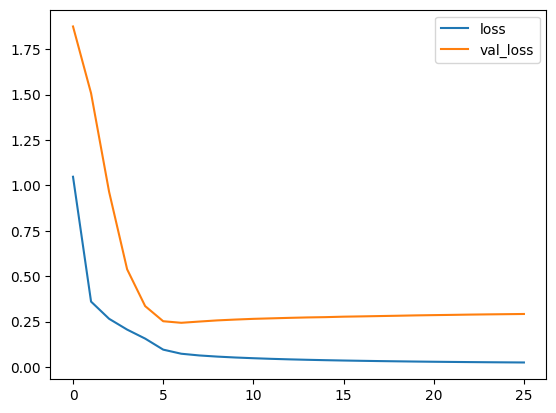

50/50 [==============================] - 1s 5ms/step
Test set accuracy: 93%


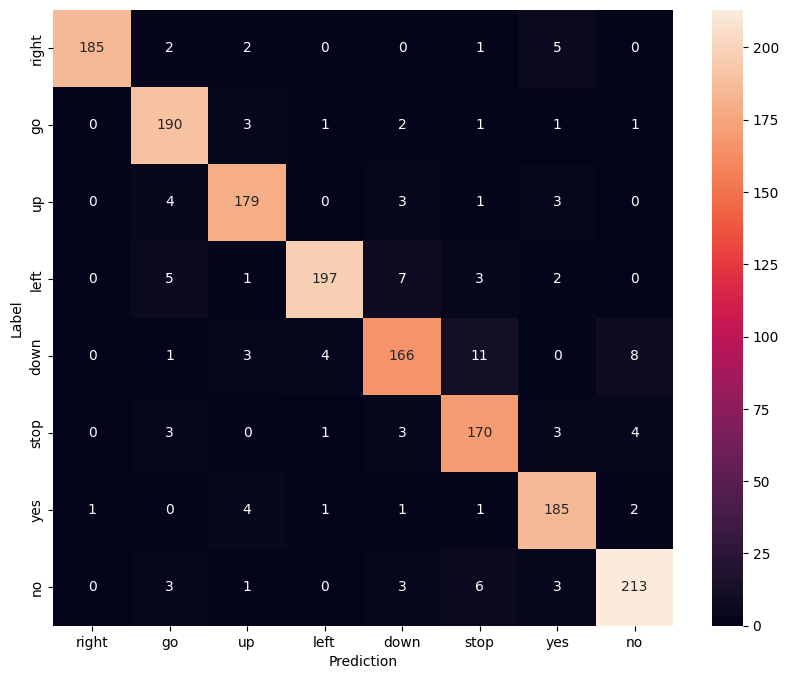

In [16]:
#norm_layer = preprocessing.Normalization()
  #norm_layer.adapt(train_ds.map(lambda x, _: x))
tiny_his,tiny_model = run_model(kws_config.BASELINE_CHECKPOINT_PATH)


In [17]:
def setup_cnnmodel(input_shape,num_labels,norm_layer,padding='valid',pool1=(2,2), pool2=(2,2),dropout_rate1=0.5, dropout_rate2=0.5,
                    strides1=(20,8),strides2=(10,4),cnn1_features=64,cnn2_features=64,dnn_features1=128, dnn_features2=128,
                    kernel1_size=(3,3),kernel2_size=(3,3)):
   model = models.Sequential([
        layers.Input(shape=input_shape),
        norm_layer,
        layers.Conv2D(cnn1_features,padding=padding, kernel_size=kernel1_size, strides=strides1,activation='gelu',use_bias=True,bias_initializer='zeros'),
        layers.MaxPool2D(pool_size=pool1),
        layers.BatchNormalization(),
        layers.Conv2D(cnn2_features, padding=padding,kernel_size=kernel2_size, strides=strides2,activation='gelu',use_bias=True,bias_initializer='zeros'),
        layers.MaxPool2D(pool_size=pool2),
        layers.BatchNormalization(),
        layers.GlobalMaxPooling2D(),
        layers.Flatten(),
        layers.Dense(dnn_features2, activation='relu',use_bias=True,bias_initializer='zeros'),
        layers.Dense(dnn_features1, activation='relu',use_bias=True,bias_initializer='zeros'),
        layers.Dense(num_labels),])
   model.summary()
   return model

def getFeatureMap():
    earlyPredictor = tf.keras.Model(test_model.inputs,test_model.get_layer(index=2).output)
    feature_maps = earlyPredictor.predict(test_img)[0]
    ix = 1
    figure,axes = plt.subplots(8,8,figsize=(12,12))
    for i  in range(64):
       r = i // 8
       c = i % 8
       spectrogram = feature_maps[:,:,ix-1]
       ax = axes[r][c]
       ax.pcolormesh(40, 4, spectrogram)
       ix += 1
    return figure


def plot_to_image(figure): #Convert the image into the tensor format
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image


def learningrate_scheduler_image(epoch,lr):
  if epoch > 5:
     lr = 0.0001
  tf.summary.scalar('learning rate', data=lr, step=epoch)
  figure = getFeatureMap()
  with kws_config.file_writer_image.as_default():
    tf.summary.image("Feature Map", plot_to_image(figure), step=epoch)
  return lr


def plot_accuracy(history):
  print("\n")
  print("\n")
  print("Plotting accuracy metric")
  print("\n")
  print("\n")
  metrics = history.history
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()

def inference(model, sample_file):
   #sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
   sample_ds = preprocess_mfccdataset([str(sample_file)])
   for spectrogram, label in sample_ds.batch(1):
      prediction = model(spectrogram)
      plt.bar(kws_config.commands, tf.nn.softmax(prediction[0]))
      plt.title(f'Predictions for "{kws_config.commands[label[0]]}"')
      plt.show()

def make_cnnmodel(input_shape,num_labels,norm_layer):
  model = setup_cnnmodel(input_shape,num_labels,norm_layer,padding='same',pool1=(1,3), pool2=(1,1),dropout_rate1=0.25, dropout_rate2=0.5,
                    strides1=(1,1),strides2=(1,1),cnn1_features=64,cnn2_features=64,dnn_features1=128, dnn_features2=32,
                    kernel1_size=(20,8),kernel2_size=(10,4))
  optimizer = tf.keras.optimizers.Adam(learning_rate=kws_config.LEARNING_RATE)
  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )
  return model

def run_cnnmodel(checkpoint_path):
  """
  Function to fit the model on the dataset and report the training time
  """
  train_ds,val_ds,test_ds = build_mfccdata()
  for mfcc,_ in train_ds.take(1):
    input_shape = mfcc.shape
  num_labels = len(kws_config.commands)
  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(train_ds.map(lambda x, _: x))
  model = make_cnnmodel(input_shape,num_labels,norm_layer)
  callbacks = get_callbacks(checkpoint_path = checkpoint_path)

  train_ds = train_ds.batch(kws_config.BATCH_SIZE)
  val_ds = val_ds.batch(kws_config.BATCH_SIZE)

  train_ds = train_ds.cache().prefetch(kws_config.AUTOTUNE)
  val_ds = val_ds.cache().prefetch(kws_config.AUTOTUNE)

  # Train model and save history
  start = time.time()
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=kws_config.NUM_EPOCHS,
    callbacks=callbacks,
  )
  end = time.time()
  print(f"Total Time taken for Model Training: {end - start} seconds.")

  plot_accuracy(history)

  test_model(model,test_ds)
  return history,model

Number of total examples: 8000
Commands: ['right' 'go' 'up' 'left' 'down' 'stop' 'yes' 'no']
Number of examples per label: 1000
Training set size 6400
Validation set size 1600
Test set size 1600
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)
Commands: ['right' 'go' 'up' 'left' 'down' 'stop' 'yes' 'no']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 98, 40, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 40, 64)        10304     
          

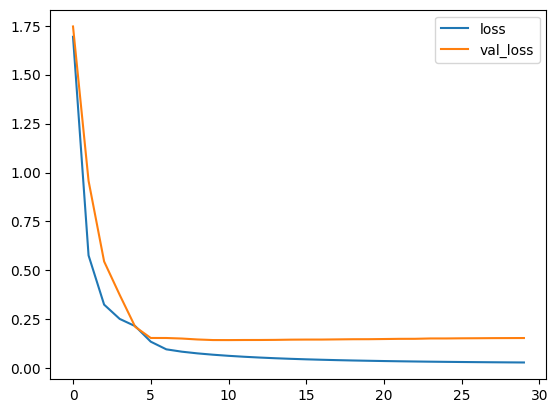

50/50 [==============================] - 1s 7ms/step
Test set accuracy: 95%


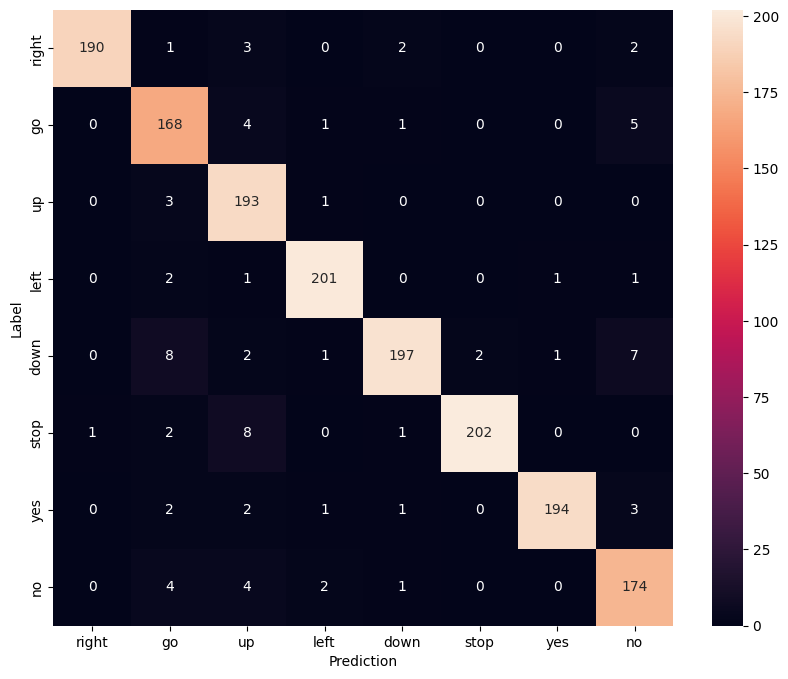

In [20]:
kws_config.model_name = "cnn_tstride"
checkpoint_path = kws_config.BASELINE_CHECKPOINT_PATH
cnn_his,model = run_cnnmodel(checkpoint_path)

In [18]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)


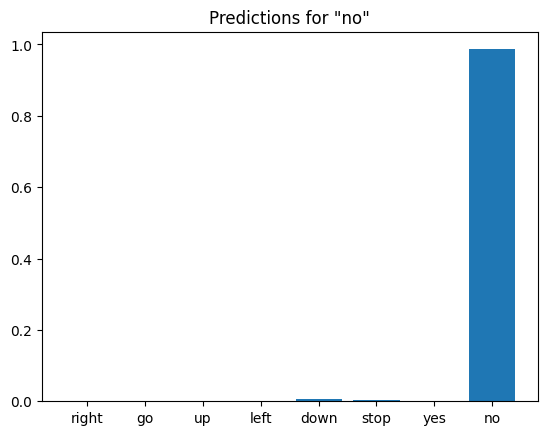

In [27]:
sample_file = os.path.join(kws_config.DATADIR_PATH,'mini_speech_commands/no/0132a06d_nohash_1.wav')
#sample_file = data_dir/'go/004ae714_nohash_0.wav'
#sample_file = data_dir/'left/00b01445_nohash_0.wav'
sample_ds =  preprocess_mfccdataset([str(sample_file)])


for spectrogram, label in sample_ds.batch(1):
  prediction = tiny_model(spectrogram)
  plt.bar(kws_config.commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{kws_config.commands[label[0]]}"')
  plt.show()


In [ ]:
#run inference

sample_file = os.path.join(kws_config.DATADIR_PATH,'mini_speech_commands/right/0132a06d_nohash_1.wav')
#sample_file = data_dir/'go/004ae714_nohash_0.wav'
#sample_file = data_dir/'left/00b01445_nohash_0.wav'
sample_ds =  preprocess_mfccdataset([str(sample_file)])


for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(kws_config.commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{kws_config.commands[label[0]]}"')
  plt.show()



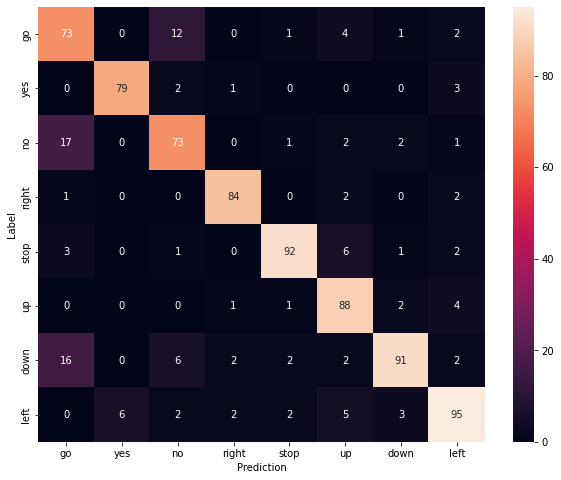

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Convert Model to TensorFlow Lite Format

###### we convert our fine tuned model to a TensorFlow Lite Model. This can be easily achieved using the Python TFLiteConverter


In [21]:
def convert_tflitemodel(model,model_name):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  float_tflite_model = converter.convert()
  tflite_models_dir = pathlib.Path(kws_config.POST_TRAINING_QUANTIZATION_PATH)
  tflite_models_dir.mkdir(exist_ok=True, parents=True)
   #tflite_model_file = tflite_models_dir/"float_tiny_model.tflite"
  #print(kws_config.FLOAT_MODEL_TFLITE)
  filename = os.path.join("./",model_name)
  print(filename)
  float_tflite_model_size = open(filename, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)
   #tflite_model_file.write_bytes(tflite_model)

In [46]:
def convert_quantmodel(model,data,model_name):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  def representative_dataset_gen():
    audio_data = []
    for mfcc,label in data:
      spec= tf.cast(mfcc,tf.float32)
      audio_data.append(spec)
    audio_data = audio_data[:100]
    audio_data = np.array(audio_data)
    audio_data = tf.data.Dataset.from_tensor_slices(audio_data).batch(1)
    for i in audio_data.take(1):
      yield [i]

  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  filename = os.path.join("./",model_name)
  tflite_model_size = open(filename, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)

In [22]:
# Helper function to run inference
def run_tflite_inference(tflite_model_path, model_type="Float"):
  # Load test data
  np.random.seed(0) # set random seed for reproducible test results.
  test_files = get_test_data(kws_config.DATADIR_PATH)
  test_ds = preprocess_mfccdataset(test_files)

  test_audio = []
  test_labels = []

  for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

  test_audio = np.array(test_audio)
  test_labels = np.array(test_labels)
  test_data = np.expand_dims(test_audio, axis=1).astype(np.float32)
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(tflite_model_path,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # For quantized models, manually quantize the input data from float to integer
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

  correct_predictions = 0
  for i in range(len(test_data)):
    interpreter.set_tensor(input_details["index"], test_data[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == test_labels[i])

  print('%s model accuracy is %f%% (Number of test samples=%d)' % (
      model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

In [ ]:
# Compute float model accuracy
convert_tflitemodel(tiny_model,kws_config.FLOAT_MODEL_TFLITE)
run_tflite_inference(kws_config.FLOAT_MODEL_TFLITE)

# Compute quantized model accuracy
#run_tflite_inference(MODEL_TFLITE, model_type='Quantized')

In [53]:
test_files = get_test_data(kws_config.DATADIR_PATH)
test_ds = preprocess_mfccdataset(test_files)
convert_quantmodel(tiny_model,test_ds,kws_config.QUANT_MODEL_TFLITE)

Number of total examples: 8000
Commands: ['right' 'go' 'up' 'left' 'down' 'stop' 'yes' 'no']
Number of examples per label: 1000
Test set size 1600
Spectrogram shape: (98, 257)
number of mel_bands 257
mel_spectrogram_shape (98, 40)
mfcc shape: (98, 40)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model is 70176 bytes


In [ ]:
convert_tflitemodel(tiny_model,kws_config.FLOAT_MODEL_TFLITE)
run_tflite_inference(kws_config.FLOAT_MODEL_TFLITE)

In [55]:
convert_quantmodel(model,test_ds,kws_config.QUANT_MODEL_TFLITE)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model is 193344 bytes
